# Context-based models

## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
# sns.set(font='IPAGothic')

from scipy.signal import find_peaks
from scipy import interpolate
from scipy.ndimage import shift

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import differential_evolution

from sklearn.metrics import mean_squared_error as mse

import itertools
from datetime import date, timedelta, datetime
import time

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams['figure.facecolor'] = 'white'

comma_strip = lambda x: x.rstrip(",")

import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

from bertopic import BERTopic
from dateutil.relativedelta import relativedelta

from IPython.display import display, clear_output

mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dormant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2023-06-27 16:28:20.360478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 16:28:20.720655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-27 16:28:20.720683: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-27 16:28:20.764432: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-27 16:28:21.811842: W tensorflow/stream_executor/platform/de

## Helper functions

In [2]:
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords \
              and token != " " \
              and token.strip() not in punctuation
              and token.strip() not in ["«", "»", "“", "”"]]
    text = " ".join(tokens)
    return text

datify = lambda x: datetime.strptime(x, '%Y-%m-%d')
textify = lambda x: x.strftime('%Y-%m-%d')

def fill_nan(arr):
    A = np.array(arr)
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

def normal(length=100, mu=0, sigma=1, boost=1):
    con = 1 / np.sqrt(2*np.pi*sigma)
    arr = [con*np.exp(-(item-mu)**2/(2*(sigma**2))) for item in range(length)]
    arr = np.array(arr)
    arr = arr/arr.max()*boost
    return arr

def squish(arr):
    return arr/arr.max()

def sharpen(arr, prom=0.8, width=20, extra=1.2):
    x = list(arr)
    peaks_p, _ = find_peaks(x, prominence=(None, prom))
    peaks_n, _ = find_peaks([-item for item in x], prominence=(None, prom))
    vals_p = [x[peak] for peak in peaks_p]
    vals_n = [x[peak] for peak in peaks_n]
    
    for idx, peak in enumerate(peaks_p):
        gaussian = normal(len(x), peak, width, vals_p[idx]*extra)
        x += gaussian

    for idx, peak in enumerate(peaks_n):
        gaussian = normal(len(x), peak, width, vals_n[idx]*extra)
        x -= gaussian
    
    x = np.array(x)
    return x, peaks_p, vals_p, peaks_n, vals_n

def normalize_pandas(a):
    ratio = 2 / (a.max() - a.min()) 
    shift = (a.max() + a.min()) / 2 
    return (a - shift) * ratio

## Preparing transactions

In [3]:
data = pd.read_csv('../DATA-MINING/OTHER-DATA/TRANS/trans_big.csv')
data['TRANS_DATE'] = pd.to_datetime(data.date)
vallab = ['food', 'outfit', 'dwelling', 'health',
          'beauty', 'remote', 'travel', 'money',
          'kids', 'nonfood', 'telecom', 'fun',
          'charity', 'misc']
data = data[np.in1d(data.group.values, vallab)]
data.sort_values(by='date', inplace=True, ignore_index=True)
data.head()

,client,card,date,amt,mcc,group,value,TRANS_DATE
0,390989,3048567,2018-01-01,878.00,5814,food,survival,2018-01-01
1,1496081,2543555,2018-01-01,495.60,5499,food,survival,2018-01-01
2,2028714,2725479,2018-01-01,30000.00,6538,money,money,2018-01-01
3,1049186,366339,2018-01-01,619.00,5499,food,survival,2018-01-01
4,2625093,3267785,2018-01-01,1596.36,5411,food,survival,2018-01-01


In [4]:
data['idate'] = pd.to_datetime(data.date)

#[(data.date>start_date)&(data.date<end_date)] \
data = data.groupby(['idate','value']).amt.sum().unstack().fillna(method='bfill')

data.head()

value,money,self_realization,socialization,survival
idate,,,,
2018-01-01,1127874.38,199990.28,383248.74,1058548.91
2018-01-02,2369992.93,600604.77,827422.97,2787420.65
2018-01-03,2615292.45,706827.30,1448923.80,3120479.74
2018-01-04,3125993.03,699248.94,1371782.89,3076443.73
2018-01-05,3187251.75,667319.70,1335841.88,3448356.93


In [5]:
def trendify(x):
    sdec = seasonal_decompose(
        x, period=14, model="additive",
        two_sided=False, extrapolate_trend="freq"
    )
    return sdec.trend

data_trend = data.copy()
data_trend = data_trend.drop(columns=["money"])
for col in data_trend.columns:
    data_trend[col] = trendify(np.array(data_trend[col]))

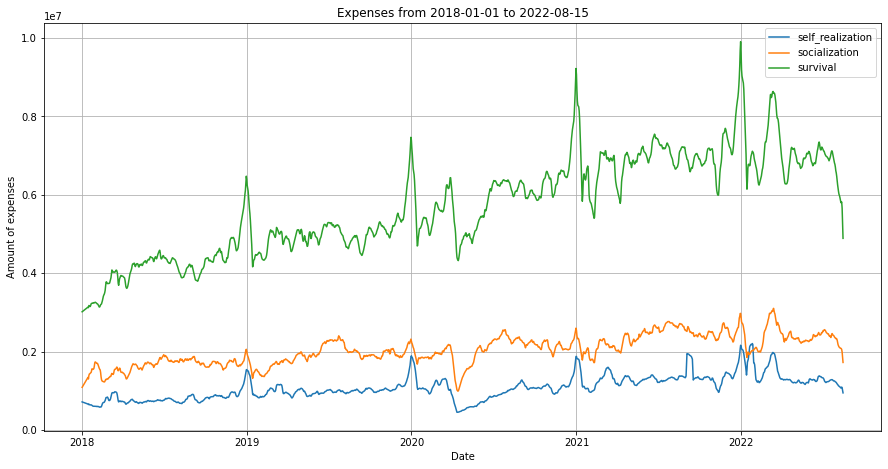

In [6]:
df = data_trend

plt.plot(df)
plt.grid()
plt.xlabel("Date")
plt.ylabel("Amount of expenses")
plt.title(f"Expenses from {df.index[0].date()} to {df.index[-1].date()}")
plt.legend(df.columns);

## Preparing news

In [7]:
try:
    news = pd.read_csv('../DATA-PROCESSING/PROCESSED-DATA/TOPICS.csv', sep=',', on_bad_lines='skip')
    news.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
    news.set_index('Date', inplace=True)
    news.index = news.index.map(datify)
    news = news.iloc[:,2:]
    
    # Cubic spline interpolation for daily values
    old_idx = news.copy().index
    new_idx = pd.date_range(start=data.index.min(),
                            end=data.index.max(),
                            freq='D')
    news = news.reindex(new_idx).interpolate(method='spline', order=3)
    news = news.ewm(span=20).mean()
    news[news<0] = 0.0
except Exception as e:
    print("ERROR", e)
    news = pd.read_csv('../DATA-MINING/SCRAPED-DATA/NEWS-2018-1-1-2022-9-1.csv',
                       sep='\t',
                       on_bad_lines='skip')
    news['title'] = news['title'].apply(preprocess_text)
    print("News are preprocessed.")
    start_d, end_d = datify(min(news['date'])), datify(max(news['date']))
    delta_d = end_d - start_d
    num_days = delta_d.days
    print(f"From {textify(start_d)} to {textify(end_d)}")
    print(f"Number of days: {num_days}")
    num_bins = int(num_days/30)
    print(f"{num_bins} is going to be the number of monthly bins.")
    
    # Topics to visualize (-2 to include all)
    num_of_topics = -2
    # Number of topics after reduction
    reduce_topics_to = 50
    # Start topic
    start_topic = 2

    timestamps = news['date'].to_list()
    titles = news['title'].to_list()
    
    topic_model = BERTopic(embedding_model='distiluse-base-multilingual-cased-v1',
                           verbose=True)
    topics, probs = topic_model.fit_transform(titles)
    topic_model.reduce_topics(titles, nr_topics=reduce_topics_to)
    topic_labels = topic_model.generate_topic_labels(nr_words=3,
                                                     topic_prefix=True,
                                                     word_length=10,
                                                     separator="_")
    
    topics_over_time = topic_model.topics_over_time(titles, timestamps, nr_bins=num_bins)
    topic_df = pd.DataFrame(topics_over_time)
    topic_df.rename(columns={"Timestamp": "Date"}, inplace=True)
    topic_df.fillna(0.0, inplace=True)
    
    new_index = pd.date_range(start=textify(start_d),
                              end=textify(end_d + relativedelta(months=-1)),
                              freq='MS')
    
    topic_df = topic_df.pivot(index="Date",
                              columns="Topic",
                              values="Frequency")
    
    topic_df = topic_df.reindex(topic_df.index.union(new_index)).interpolate(method='time')
    topic_df = topic_df.reindex(new_index)
    topic_df.set_axis(topic_labels, axis=1, inplace=True)
    topic_df.fillna(0.0, inplace=True)
    
    topic_df.to_csv('../DATA-PROCESSING/PROCESSED-DATA/TOPICS.csv', sep=',')
    
    # validate working file
    news = pd.read_csv('../DATA-PROCESSING/PROCESSED-DATA/TOPICS.csv', sep=',', on_bad_lines='skip')
    news.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
    news.set_index('Date', inplace=True)
    news.index = news.index.map(datify)
    news = news.iloc[:,2:]
    
    # Cubic spline interpolation for daily values
    old_idx = news.copy().index
    new_idx = pd.date_range(start=data.index.min(),
                            end=data.index.max(),
                            freq='D')
    news = news.reindex(new_idx).interpolate(method='spline', order=3)
    news = news.ewm(span=20).mean()
    news[news<0] = 0.0

Number of topics: 48


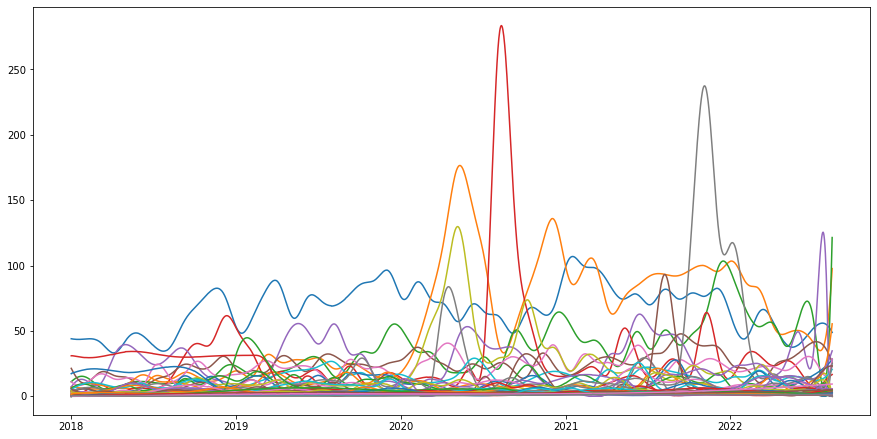

In [8]:
print(f"Number of topics: {len(news.columns)}")
plt.plot(news);
if len(news.columns) <= 35:
    plt.legend(news.columns);

Text(0.5, 1.0, '9 topics left (more than 5 on average and non-stationary)')

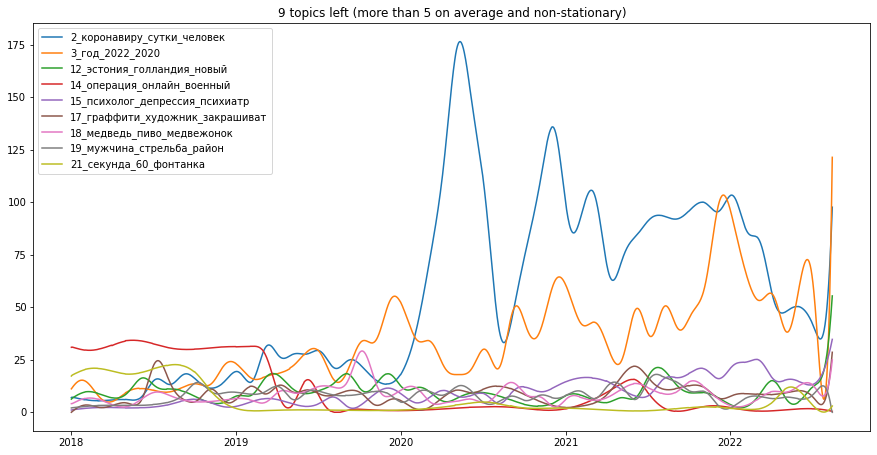

In [9]:
# desired_topics = 20
thr = 5

for col in news.columns:
    result = smt.stattools.adfuller(news[col])
    stat = (result[1] < 0.05) and (result[0] < result[4]['5%'])
    if stat or news[col].mean() < thr:
        news = news.drop(columns=[col])

plt.plot(news);
plt.legend(news.columns);
plt.title(f"{len(news.columns)} topics left (more than {thr} on average and non-stationary)")

In [10]:
news.head()

,2_коронавиру_сутки_человек,3_год_2022_2020,12_эстония_голландия_новый,14_операция_онлайн_военный,15_психолог_депрессия_психиатр,17_граффити_художник_закрашиват,18_медведь_пиво_медвежонок,19_мужчина_стрельба_район,21_секунда_60_фонтанка
2018-01-01,7.000000,11.159091,6.265152,30.946970,1.054475,0.000000,4.106061,2.053030,17.265152
2018-01-02,7.141089,11.463274,6.520120,31.035593,1.143523,0.195244,4.093184,2.118824,17.542015
2018-01-03,7.153427,11.759818,6.695555,31.019123,1.187688,0.375170,4.165194,2.153718,17.700326
2018-01-04,7.133294,12.049047,6.850895,30.976339,1.220861,0.549833,4.258452,2.181123,17.829516
2018-01-05,7.100009,12.330361,6.997817,30.923100,1.249797,0.720940,4.360060,2.205707,17.947352


In [11]:
type(news.index[0])

pandas._libs.tslibs.timestamps.Timestamp

## Model class

In [12]:
class Model:
    trans = None
    news = None
    date_start = None
    date_pred = None
    date_end = None
    # start --- pred --- end
    # fitting | prediction
    
    trans_train = None
    news_train = None
    trans_test = None
    news_test = None
    
    arimax_model = None
    arimax_topics = []
    
    coeffs_ab = {}
    fi_train = None
    gi_train = None
    fi_test = None
    gi_test = None
    
    dsin = None
    dcos = None
    rrmse_dict_arimax = {}
    corr_abs_dict = {}
    pred_coeffs_osc = {}
    
    def __init__(self, trans, news, d_start=None, d_pred=None, d_end=None):
        self.trans = trans
        self.news = news
        
        dsin_raw = np.sin(self.trans.index.day.values*2*np.pi / 30)
        dcos_raw = np.cos(self.trans.index.day.values*2*np.pi / 30)
        self.dsin = pd.Series(data=dsin_raw, index=self.trans.index)
        self.dcos = pd.Series(data=dcos_raw, index=self.trans.index)
        
        # PLACEHOLDER
        self.coeffs_ab = {"a": 0.037, "b": 0.002}
        
        if d_start is None:
            self.date_start = self.trans.index[0]
        else:
            self.date_start = datetime.strptime(d_start, "%Y-%m-%d")
        if d_pred is None:
            half = len(self.trans) // 2
            self.date_pred = self.trans.index[half]
        else:
            self.date_pred = datetime.strptime(d_pred, "%Y-%m-%d")
        
        if d_end is None:
            self.date_end = self.trans.index[-1]
        else:
            self.date_end = datetime.strptime(d_end, "%Y-%m-%d")
            
        self.trans_train = self.trans[
            (self.trans.index >= self.date_start) & (self.trans.index < self.date_pred)
        ].copy()
        self.trans_test = self.trans[
            (self.trans.index >= self.date_pred) & (self.trans.index <= self.date_end)
        ].copy()
        
        self.news_train = self.news[
            (self.news.index >= self.date_start) & (self.news.index < self.date_pred)
        ].copy()
        self.news_test = self.news[
            (self.news.index >= self.date_pred) & (self.news.index <= self.date_end)
        ].copy()
        
        self.fi_train = np.zeros(len(self.news_train.iloc[:,0]))
        self.gi_train = np.zeros(len(self.news_train.iloc[:,0]))
        self.fi_train = np.zeros(len(self.news_test.iloc[:,0]))
        self.gi_train = np.zeros(len(self.news_test.iloc[:,0]))
        
    def update_dates(self, new_end=None):
        # NOT TESTED ---------------------------------------------------------------------
        self.date_pred = self.date_end
        if new_end is None:
            self.date_end = self.trans.index[-1]
        else:
            self.date_end = datetime.strptime(new_end, "%Y-%m-%d")
        
    def f(self, t, a, b, c, test=False):
        # X------------------
        if test:
            x = np.array(list(self.fi_test))
        else:
            x = np.array(list(self.fi_train))
        x /= x.max()
        x = x[int(t)]
        # X'-----------------
        if test:
            dx = np.array(list(self.gi_test))
        else:
            dx = np.array(list(self.gi_train))
        dx /= dx.max()
        dx = dx[int(t)]
        # return [f(t), g(t)]
        f_t = a*x - b*self.dcos[int(t) - 1]
        g_t = c*dx
        return [f_t, g_t]
            
    def search(self, model="arimax"):
        if model.lower() == "arimax":
            coeffs = []
            lags = []
            for col in self.news_train.columns:
                max_coef = 0
                min_coef = 0
                max_lag = 0
                min_lag = 0
                for lag in range(64):
                    coef = self.news_train[col].corr(self.trans_train.shift(lag))
                    if coef > max_coef:
                        max_coef = coef
                        max_lag = lag
                    if coef < min_coef:
                        min_coef = coef
                        min_lag = lag
                if abs(min_coef) > abs(max_coef):
                    coeffs.append(abs(min_coef))
                    lags.append(min_coef)
                else:
                    coeffs.append(abs(max_coef))
                    lags.append(max_coef)
            coeffs = np.array(coeffs)
            coeffs /= coeffs.sum()
            self.corr_abs_dict = dict(zip(self.news_train.columns, coeffs))
            
        elif model.lower() == "osc":
            coeffs_gi = []
            coeffs_fi = []
            lags_gi = []
            lags_fi = []
            for col in self.news_train.columns:
                max_coef = 0
                min_coef = 0
                max_lag = 0
                min_lag = 0
                for lag in range(64):
                    coef = self.news_train[col].corr(self.trans_train.shift(lag))
                    if coef > max_coef:
                        max_coef = coef
                        max_lag = lag
                    if coef < min_coef:
                        min_coef = coef
                        min_lag = lag
                coeffs_gi.append(max_coef)
                coeffs_fi.append(min_coef)
                lags_gi.append(max_lag)
                lags_fi.append(min_lag)
            coeffs_gi = np.array(coeffs_gi)
            coeffs_fi = np.array(coeffs_fi)
            coeffs_gi /= coeffs_gi.sum()
            coeffs_fi /= coeffs_fi.sum()
            
            fi_train = np.zeros(len(self.news_train.iloc[:,0]))
            gi_train = np.zeros(len(self.news_train.iloc[:,0]))
            fi_test = np.zeros(len(self.news_test.iloc[:,0]))
            gi_test = np.zeros(len(self.news_test.iloc[:,0]))
            for i in range(len(coeffs_gi)):
                # TRAIN TEST
                cur_g_tr = np.array(self.news_train.iloc[:,i])
                cur_f_tr = np.array(self.news_train.iloc[:,i])
                cur_g_te = np.array(self.news_test.iloc[:,i])
                cur_f_te = np.array(self.news_test.iloc[:,i])
                # shift(cur_g, lags_gi[i], mode='nearest')
                fi_train += coeffs_fi[i] * cur_f_tr
                gi_train += coeffs_gi[i] * cur_g_tr
                fi_test += coeffs_fi[i] * cur_f_te
                gi_test += coeffs_gi[i] * cur_g_te
            self.fi_train = pd.Series(data=fi_train, index=self.news_train.index)
            self.gi_train = pd.Series(data=gi_train, index=self.news_train.index)
            self.fi_test = pd.Series(data=fi_test, index=self.news_test.index)
            self.gi_test = pd.Series(data=gi_test, index=self.news_test.index)
    
    def shift_fi_gi(self, lag=-21):
        # TRAIN
        idx = self.fi_train.index
        self.fi_train = pd.Series(data=shift(self.fi_train, lag, mode='nearest'), index=idx)
        self.gi_train = pd.Series(data=shift(self.gi_train, lag, mode='nearest'), index=idx)
        # TEST
        idx = self.fi_test.index
        self.fi_test = pd.Series(data=shift(self.fi_test, lag, mode='nearest'), index=idx)
        self.gi_test = pd.Series(data=shift(self.gi_test, lag, mode='nearest'), index=idx)
    
    def sharpen_fi(self, prom=100, width=10, extra=5):
        # TRAIN
        idx = self.fi_train.index
        fn, _, _, _, _ = sharpen(self.fi_train, prom=prom, width=width, extra=extra)
        self.fi_train = pd.Series(data=fn, index=idx)
        # TEST
        idx = self.fi_test.index
        fn, _, _, _, _ = sharpen(self.fi_test, prom=prom, width=width, extra=extra)
        self.fi_test = pd.Series(data=fn, index=idx)
    
    def sharpen_gi(self, prom=100, width=10, extra=5):
        # TRAIN
        idx = self.gi_train.index
        gn, _, _, _, _ = sharpen(self.gi_train, prom=prom, width=width, extra=extra)
        self.gi_train = pd.Series(data=gn, index=idx)
        # TEST
        idx = self.gi_test.index
        gn, _, _, _, _ = sharpen(self.gi_test, prom=prom, width=width, extra=extra)
        self.gi_test = pd.Series(data=gn, index=idx)
    
    def train_arimax(self, topics=5):
        self.search(model="arimax")
        arr = [
            k for k, v in sorted(
                self.corr_abs_dict.items(),
                key=lambda item: item[1]
            )
        ][:topics]
        self.arimax_topics = arr
        exog = self.news_train[arr]
        
        arimax = sm.tsa.statespace.SARIMAX(
            self.trans_train,
            order=(7,1,7),
            seasonal_order=(0,0,0,0),
            exog=exog,
            freq='D',
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        
        self.arimax_model = arimax
            
        pred = arimax.predict(self.date_start, self.date_pred-timedelta(1), exog=exog)
        assert len(self.trans_train) == len(pred), "true and pred trans lengths unequal"
        rmse = mse(self.trans_train, pred, squared=False)
        rrmse = rmse / self.trans_train.mean()

        return pred, rrmse
    
    def train_osc_helper(self, args, final=False, predict=False):
        if not predict:
            u = self.trans_train.copy()
        else:
            u = self.trans_test.copy()
        u /= u.max() # Normalization
        
        x_bias, cos_bias, dx_bias = args[0], args[1], args[2]
        x = [0.0]     # Initial state of X(t)
        dx = [0.0]    # Initial state of dX/dt
        T = np.linspace(0, len(u)-1, len(u))
        h = (T[-1] - T[0]) / len(T)
        a = self.coeffs_ab["a"]
        b = self.coeffs_ab["b"]
        A = np.array([[0., 1.],
                      [-b, -a]])

        for t in T:
            Y = np.array([[x[-1], dx[-1]]]).T
            k1 = (np.dot(A, Y)        + np.array([self.f(t,     x_bias, cos_bias, dx_bias, predict)]).T)*h
            k2 = (np.dot(A, (Y+k1/2)) + np.array([self.f(t+h/2, x_bias, cos_bias, dx_bias, predict)]).T)*h
            k3 = (np.dot(A, (Y+k2/2)) + np.array([self.f(t+h/2, x_bias, cos_bias, dx_bias, predict)]).T)*h
            k4 = (np.dot(A, (Y+k3))   + np.array([self.f(t+h,   x_bias, cos_bias, dx_bias, predict)]).T)*h
            Y1 = Y + (k1 + 2*k2 + 2*k3 + k4) / 6
            x.append(Y1[0, 0])
            dx.append(Y1[1, 0])
        x = np.array(x)*b 
        dx = np.array(dx)*b 

        truth = np.array(u.values - u.values[0])
        pred = np.array(x[1:])
        loss = np.linalg.norm(pred - truth) / np.sqrt(len(truth))
        
        # print(f"{loss:.4f}%", end=" ")
        
        if final:
            return x, T, h
        return loss
    
    def train_osc(self, biases=None, bounds=None, workers=4):
        self.search(model="osc")
        
        # CONDITIONAL-----------------------------------------------------------------
        self.sharpen_fi()
        self.shift_fi_gi()
        
        if bounds is None:
            bounds = [(-50.0, 50.0), (-20.0, 20.0), (0.001, 1.0)]
            # bounds = [(-500.0, 500.0), (-200.0, 200.0), (0.0001, 1.0)]
        result = differential_evolution(self.train_osc_helper, bounds, workers=workers)
        x_bias, cos_bias, dx_bias = result.x[0], result.x[1], result.x[2]
        
        x, T, h = self.train_osc_helper([x_bias, cos_bias, dx_bias], final=True)
        f_out = np.array([self.f(t, x_bias, cos_bias, dx_bias, False)[0] / 50 for t in T])
        g_out = np.array([self.f(t, x_bias, cos_bias, dx_bias, False)[1] for t in T])
        
        u0 = self.trans_train.values[0]
        u_max = self.trans_train.max()
        
        x     *= u_max
        f_out *= u_max
        g_out *= u_max
        x     += u0
        f_out += u0
        g_out += u0
        
        x = pd.Series(data=x[1:], index=self.trans_train.index)
        f_out_ser = pd.Series(data=f_out, index=x.index)
        g_out_ser = pd.Series(data=g_out, index=x.index)
        
        assert len(self.trans_train) == len(x), "true and pred trans lengths unequal"
        rmse = mse(self.trans_train, x, squared=False)
        rrmse = rmse / self.trans_train.mean()
        
        self.pred_coeffs_osc[f"{self.date_start}-{self.date_pred}"] = {
            "x_bias": x_bias,
            "cos_bias": cos_bias,
            "dx_bias": dx_bias
        }
        
        return x, f_out_ser, g_out_ser, rrmse

    def predict_arimax(self):
        pred = self.arimax_model.predict(self.date_pred, self.date_end, exog=self.news_test[self.arimax_topics])
        assert len(self.trans_test) == len(pred), "true and pred trans lengths unequal"
        rmse = mse(self.trans_test, pred, squared=False)
        rrmse = rmse / self.trans_test.mean()

        return pred, rrmse
    
    def predict_osc(self):
        coeff_dict = self.pred_coeffs_osc[f"{self.date_start}-{self.date_pred}"]
        x_bias = coeff_dict["x_bias"]
        cos_bias = coeff_dict["cos_bias"]
        dx_bias = coeff_dict["dx_bias"]
        biases = [x_bias, cos_bias, dx_bias]
        
        x, T, h = self.train_osc_helper(biases, final=True, predict=True)
        f_out = np.array([self.f(t, x_bias, cos_bias, dx_bias, True)[0] / 50 for t in T])
        g_out = np.array([self.f(t, x_bias, cos_bias, dx_bias, True)[1] for t in T])
        
        u0 = self.trans_test.values[0]
        u_max = self.trans_test.max()
        
        x     *= u_max
        f_out *= u_max
        g_out *= u_max
        x     += u0
        f_out += u0
        g_out += u0
        
        x = pd.Series(data=x[1:], index=self.trans_test.index)
        f_out_ser = pd.Series(data=f_out, index=x.index)
        g_out_ser = pd.Series(data=g_out, index=x.index)
        
        assert len(self.trans_test) == len(x), "true and pred trans lengths unequal"
        rmse = mse(self.trans_test, x, squared=False)
        rrmse = rmse / self.trans_test.mean()
        
        return x, f_out_ser, g_out_ser, rrmse

### Debug only

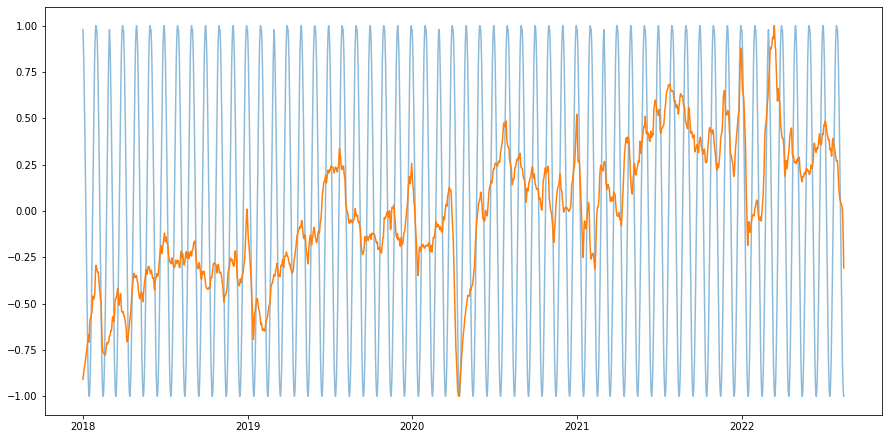

In [13]:
md = Model(data_trend["socialization"], news, d_start=None, d_pred="2019-05-01")

plt.plot(md.dcos, alpha=0.5)
plt.plot(normalize_pandas(md.trans))

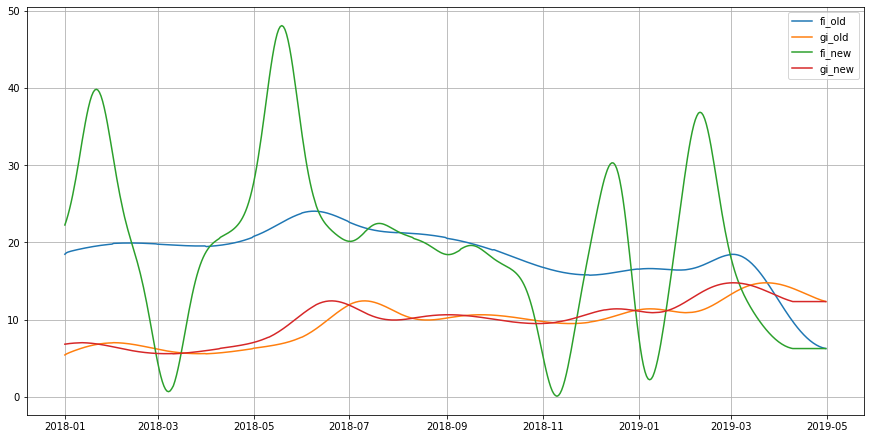

In [14]:
md = Model(data_trend["socialization"], news, d_start=None, d_pred="2019-05-01")
md.search(model="osc")

plt.plot(md.fi_train, label="fi_old")
plt.plot(md.gi_train, label="gi_old")

md.sharpen_fi(extra=1)
md.shift_fi_gi()

plt.plot(md.fi_train, label="fi_new")
plt.plot(md.gi_train, label="gi_new")

plt.legend()
plt.grid()

In [15]:
def ARIMAX_plot(category="socialization", d_start="2020-03-01", d_pred="2020-11-01", d_end="2020-12-01"):
    begin_compute = time.time()
    md = Model(
        data_trend[category],
        news,
        d_start=d_start,
        d_pred=d_pred,
        d_end=d_end
    )
    
    topics = 5
    fit, rrmse_fit = md.train_arimax(topics=topics)
    pred, rrmse_pred = md.predict_arimax()
    delta_compute = time.time() - begin_compute

    plt.plot(md.trans, label="true")
    plt.plot(fit, label="fit")
    plt.plot(pred, label="pred")
    plt.grid();
    plt.legend();
    plt.title(f"ARIMAX {topics} best (rRMSEC {rrmse_fit*100:.2f}% rRMSEP {rrmse_pred*100:.2f}% time {int(delta_compute)}s)");
    plt.xlim((datify(d_start)-relativedelta(months=1), datify(d_end)+relativedelta(months=1)))
#     plt.ylim((md.trans.min()-2.5e5, md.trans.max()+2.5e5))

In [16]:
def OSC_plot(category="socialization", d_start="2020-03-01", d_pred="2020-11-01", d_end="2020-12-01", plot_fg=True):
    begin_compute = time.time()
    md = Model(
        data_trend[category],
        news,
        d_start=d_start,
        d_pred=d_pred,
        d_end=d_end
    )

    x_fit, f_out_fit, g_out_fit, rrmse_fit = md.train_osc()
    x_pred, f_out_pred, g_out_pred, rrmse_pred = md.predict_osc()
    delta_compute = time.time() - begin_compute

    x = x_fit.append(x_pred)
    f_out = f_out_fit.append(f_out_pred)
    g_out = g_out_fit.append(g_out_pred)
    
    plt.plot(x, label="x(t)")
    plt.plot(md.trans, label="true")
    if plot_fg:
        plt.plot(f_out, ls=':', label="f(t)")
        plt.plot(g_out, ls=':', label="g(t)")
    plt.axvline(x=md.date_pred, ymin=0.05, ymax=0.95, color='black', alpha=0.5, ls=":", label="prediction date")
    plt.grid();
    plt.legend();
    plt.title(f"Runge-Kutta, a={md.coeffs_ab['a']} b={md.coeffs_ab['b']} (rRMSEC {rrmse_fit*100:.2f}% rRMSEP {rrmse_pred*100:.2f}% time {int(delta_compute)}s)");
    plt.xlim((datify(d_start)-relativedelta(months=1), datify(d_end)+relativedelta(months=1)))
#     plt.ylim((md.trans.min()-2.5e5, md.trans.max()+2.5e5))

## ARIMAX predictions

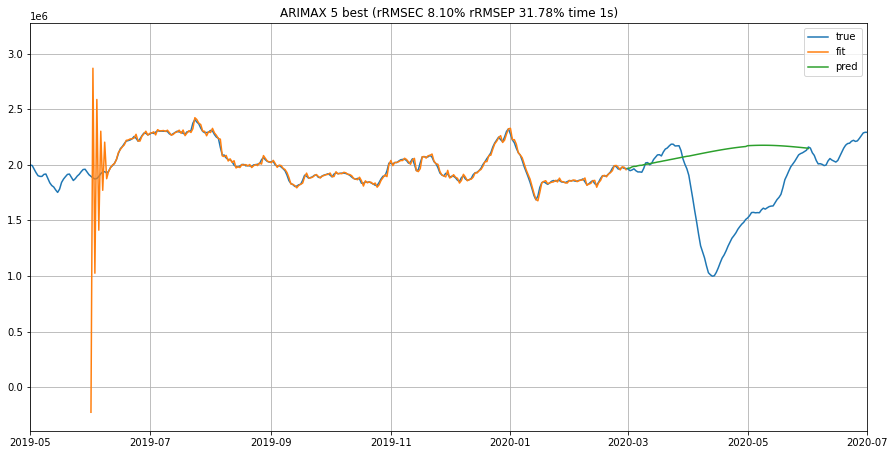

In [17]:
ARIMAX_plot(d_start="2019-06-01", d_pred="2020-03-01", d_end="2020-06-01")

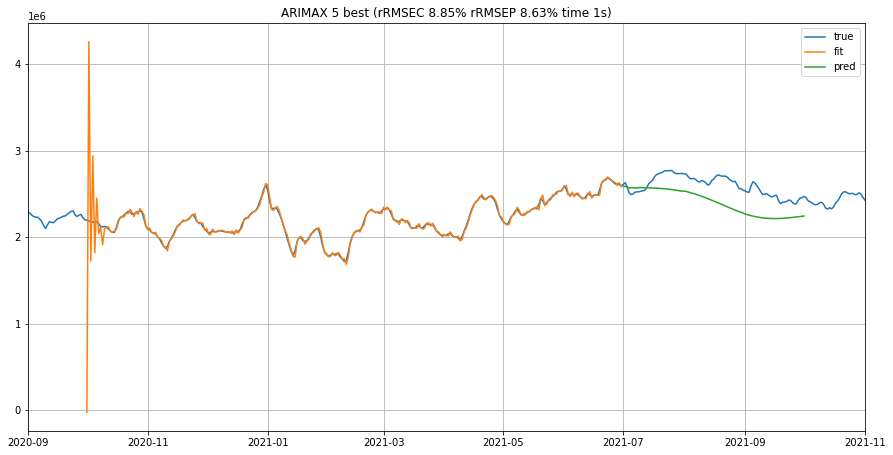

In [18]:
ARIMAX_plot(d_start="2020-10-01", d_pred="2021-07-01", d_end="2021-10-01")

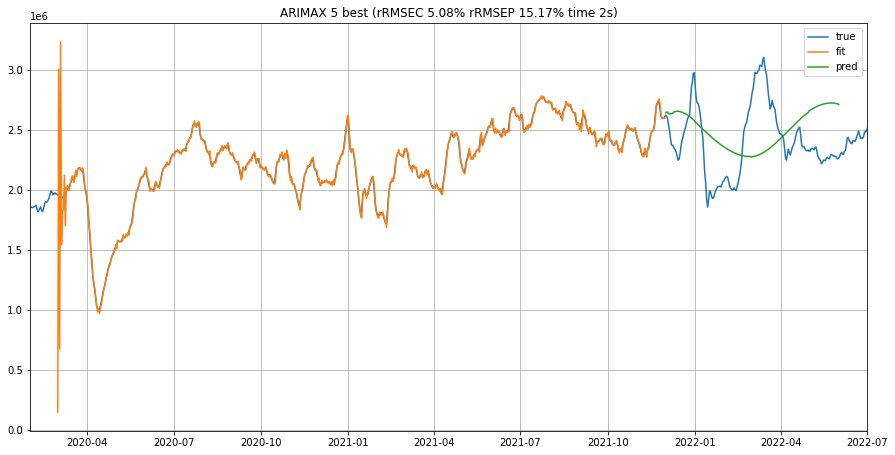

In [19]:
ARIMAX_plot(d_start="2020-03-01", d_pred="2021-12-01", d_end="2022-06-01")

Main conclusion: autoregressive models do NOT work well on non-stationary data.

A way to solve this - oscillator model.

## Oscillator predictions

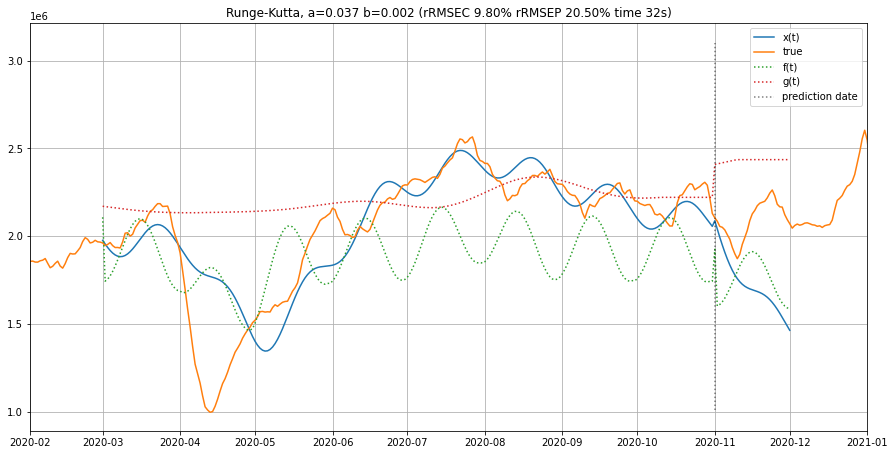

In [20]:
OSC_plot(d_start="2020-03-01", d_pred="2020-11-01", d_end="2020-12-01", plot_fg=True)

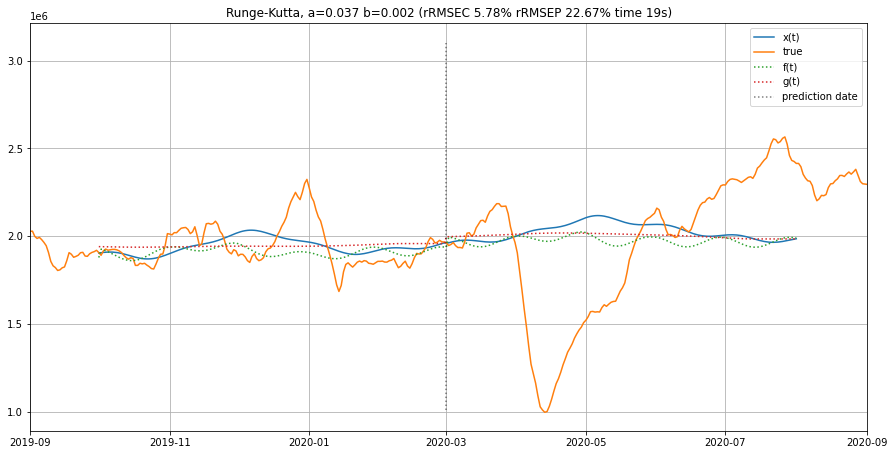

In [21]:
OSC_plot(d_start="2019-10-01", d_pred="2020-03-01", d_end="2020-08-01", plot_fg=True)

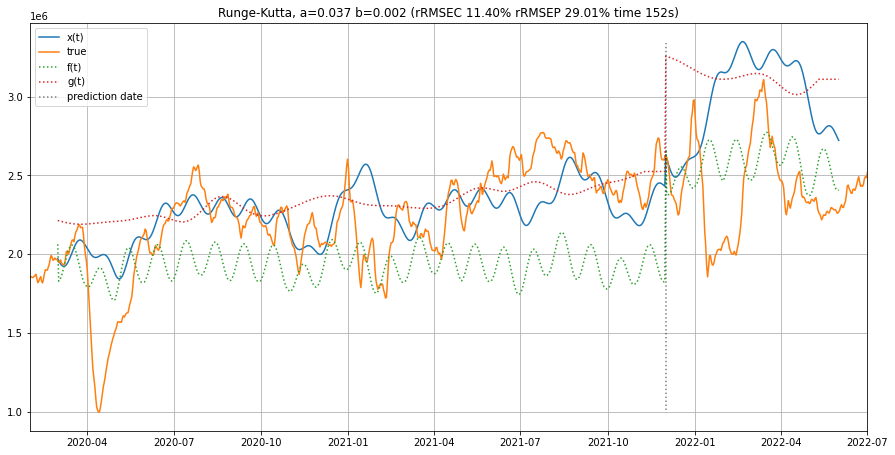

In [22]:
OSC_plot(d_start="2020-03-01", d_pred="2021-12-01", d_end="2022-06-01", plot_fg=True)

## Experiment automation

In [23]:
print(textify(data_trend.index.min()), "\t", textify(data_trend.index.max()))

2018-01-01 	 2022-08-15


In [24]:
def is_stationary(arr):
    """Returns bool and pvalue"""
    result = smt.stattools.adfuller(np.array(arr))
    stat = (result[1] < 0.05) and (result[0] < result[4]['5%'])
    return stat, result[1]

is_stationary(data["socialization"])

(True, 0.0037794966228279873)

In [25]:
def ARIMAX_eval(category="socialization", d_start=None, d_pred=None, d_end=None):
    begin_compute = time.time()
    md = Model(
        data_trend[category],
        news,
        d_start=d_start,
        d_pred=d_pred,
        d_end=d_end
    )
    topics = 5
    _, rrmse_fit = md.train_arimax(topics=topics)
    _, rrmse_pred = md.predict_arimax()
    delta_compute = time.time() - begin_compute
    stat_fit = is_stationary(md.trans_train)
    stat_pred = is_stationary(md.trans_test)
    return {
        "START": d_start,
        "PRED": d_pred,
        "END": d_end,
        "rRMSEC": rrmse_fit,
        "rRMSEP": rrmse_pred,
        "TIME": delta_compute,
        "TRAIN_IS_STAT": stat_fit[0],
        "TRAIN_PVAL": stat_fit[1],
        "TEST_IS_STAT": stat_pred[0],
        "TEST_PVAL": stat_pred[1]
    }
    
def OSC_eval(category="socialization", d_start=None, d_pred=None, d_end=None):
    begin_compute = time.time()
    md = Model(
        data_trend[category],
        news,
        d_start=d_start,
        d_pred=d_pred,
        d_end=d_end
    )
    _, _, _, rrmse_fit = md.train_osc()
    _, _, _, rrmse_pred = md.predict_osc()
    delta_compute = time.time() - begin_compute
    stat_fit = is_stationary(md.trans_train)
    stat_pred = is_stationary(md.trans_test)
    return {
        "START": d_start,
        "PRED": d_pred,
        "END": d_end,
        "rRMSEC": rrmse_fit,
        "rRMSEP": rrmse_pred,
        "TIME": delta_compute,
        "TRAIN_IS_STAT": stat_fit[0],
        "TRAIN_PVAL": stat_fit[1],
        "TEST_IS_STAT": stat_pred[0],
        "TEST_PVAL": stat_pred[1]
    }

ARIMAX_eval(d_start="2019-11-01", d_pred="2020-08-01", d_end="2020-11-01")

{'START': '2019-11-01',
 'PRED': '2020-08-01',
 'END': '2020-11-01',
 'rRMSEC': 0.10904209185167582,
 'rRMSEP': 0.10666715700232049,
 'TIME': 1.230818510055542,
 'TRAIN_IS_STAT': False,
 'TRAIN_PVAL': 0.3693415775623657,
 'TEST_IS_STAT': False,
 'TEST_PVAL': 0.0824605362815275}

In [26]:
try:
    df_eval = pd.read_csv("./evaluations.csv")
except:
    evals = []
    glob_start = data_trend.index.min()
    glob_end = data_trend.index.max()

    exp_id = 0
#     stop=False

    for mn in range(3, 13, 3):
#         if stop:
#             break
        offset = 0
        while glob_start + relativedelta(months=(mn+offset)) < glob_end:
            start = glob_start + relativedelta(months=offset)
            end = start + relativedelta(months=mn)
            diff = (end - start).days
            pred = start + timedelta(int(0.75*diff))

            for category in data_trend.columns:
                arimax_dict = ARIMAX_eval(category=category,
                            d_start=textify(start),
                            d_pred=textify(pred),
                            d_end=textify(end))
                arimax_dict["ID"] = f"ARI{exp_id:03d}"
                arimax_dict["CATEGORY"] = category
                evals.append(arimax_dict)

                osc_dict = OSC_eval(category=category,
                            d_start=textify(start),
                            d_pred=textify(pred),
                            d_end=textify(end))
                osc_dict["ID"] = f"OSC{exp_id:03d}"
                osc_dict["CATEGORY"] = category
                evals.append(osc_dict)

            print(f"{exp_id} finished")
            if exp_id > 0 and exp_id % 50 == 0:
                bu = pd.DataFrame(evals)
                bu.to_csv(f"./backups/evaluations_to_{exp_id-1}.csv", index=False)
            offset += 1
            exp_id += 1
#             stop=True
#             break
            
    df_eval = pd.DataFrame(evals)
    df_eval.to_csv("./evaluations.csv", index=False)
    df_eval = pd.read_csv("./evaluations.csv")

In [27]:
df_eval = pd.read_csv("./evaluations.csv")
df_eval["START"] = pd.to_datetime(df_eval["START"])
df_eval["PRED"] = pd.to_datetime(df_eval["PRED"])
df_eval["END"] = pd.to_datetime(df_eval["END"])
df_eval.head(10)

,START,PRED,END,rRMSEC,rRMSEP,TIME,TRAIN_IS_STAT,TRAIN_PVAL,TEST_IS_STAT,TEST_PVAL,ID,CATEGORY
0,2018-01-01,2018-03-09,2018-04-01,0.422633,0.674272,0.424022,False,0.984249,False,0.088251,ARI000,self_realization
1,2018-01-01,2018-03-09,2018-04-01,0.060829,0.107072,5.227613,False,0.984249,False,0.088251,OSC000,self_realization
2,2018-01-01,2018-03-09,2018-04-01,0.357014,0.436986,0.404090,True,0.032935,False,0.996948,ARI000,socialization
3,2018-01-01,2018-03-09,2018-04-01,0.069582,0.146639,3.847514,True,0.032935,False,0.996948,OSC000,socialization
4,2018-01-01,2018-03-09,2018-04-01,0.126005,0.308038,0.448277,False,0.997796,False,0.973432,ARI000,survival
5,2018-01-01,2018-03-09,2018-04-01,0.036013,0.049881,4.995211,False,0.997796,False,0.973432,OSC000,survival
6,2018-02-01,2018-04-08,2018-05-01,2.969947,0.649210,0.420714,False,0.336319,True,0.008799,ARI001,self_realization
7,2018-02-01,2018-04-08,2018-05-01,0.124704,0.051394,3.949249,False,0.336319,True,0.008799,OSC001,self_realization
8,2018-02-01,2018-04-08,2018-05-01,5.541486,0.682972,0.546761,True,0.010037,True,0.028804,ARI001,socialization
9,2018-02-01,2018-04-08,2018-05-01,0.135464,0.158202,3.956300,True,0.010037,True,0.028804,OSC001,socialization


In [28]:
def color_picker(d):
    if d <= 0.1:
        return "green"
    elif d <= 0.2:
        return "orange"
    else:
        return "red"

(0.0, 1.0)

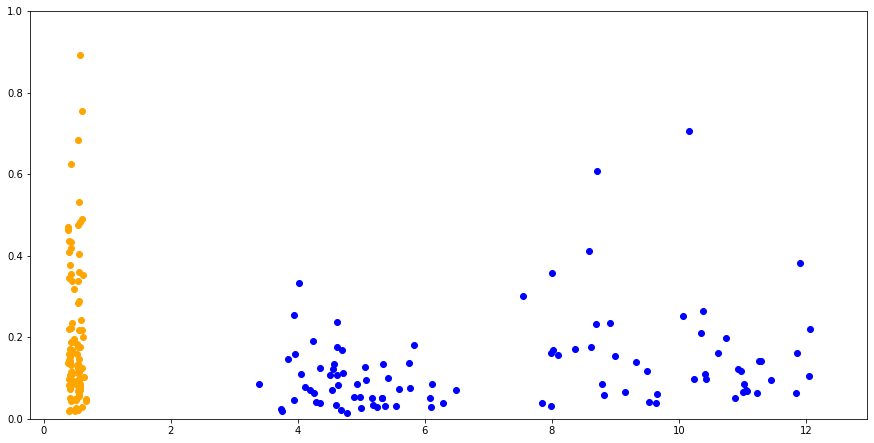

In [29]:
x = df_eval[df_eval["CATEGORY"]=="socialization"]
x1 = x[x["ID"].apply(lambda x: x.startswith("ARI"))]
x2 = x[x["ID"].apply(lambda x: x.startswith("OSC"))]
plt.scatter(x1["TIME"], x1["rRMSEP"], color="orange")
plt.scatter(x2["TIME"], x2["rRMSEP"], color="blue")
plt.ylim((0, 1))

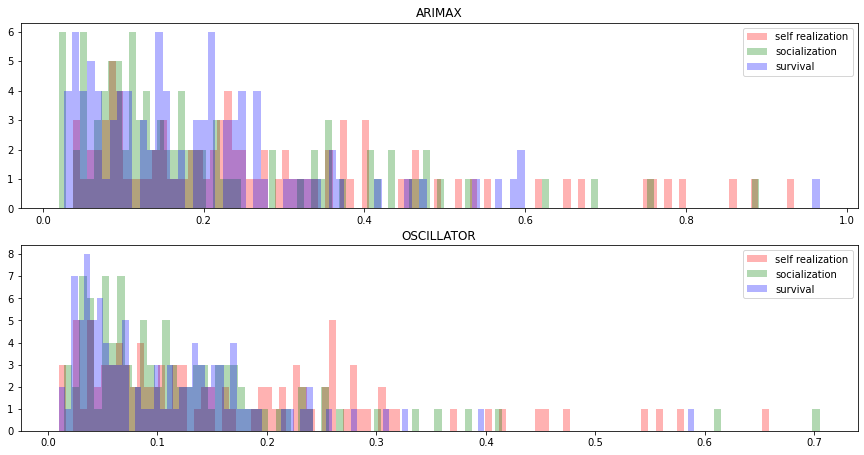

In [30]:
colors = ["red", "green", "blue"]

for i, category in enumerate(data_trend.columns):
    x = df_eval[df_eval["CATEGORY"]==category]
    x = x[x["ID"].apply(lambda x: x.startswith("ARI"))]
    x["DIFF"] = (x["END"]-x["PRED"]).apply(lambda d: d.days)
#     x = x[x["DIFF"]<30]
    x = x[x["rRMSEP"]<=1]
    flat = np.array(x["rRMSEP"])
    plt.subplot(2, 1, 1)
    plt.hist(flat, bins=100, color=colors[i], alpha=0.3, label=" ".join(category.split("_")));
    
plt.legend();
plt.title("ARIMAX");
    
for i, category in enumerate(data_trend.columns):
    x = df_eval[df_eval["CATEGORY"]==category]
    x = x[x["ID"].apply(lambda x: x.startswith("OSC"))]
    x["DIFF"] = (x["END"]-x["PRED"]).apply(lambda d: d.days)
#     x = x[x["DIFF"]<30]
    x = x[x["rRMSEP"]<=1]
    flat = np.array(x["rRMSEP"])
    plt.subplot(2, 1, 2)
    plt.hist(flat, bins=100, color=colors[i], alpha=0.3, label=" ".join(category.split("_")));

plt.legend();
plt.title("OSCILLATOR");

(0.0, 2.0)

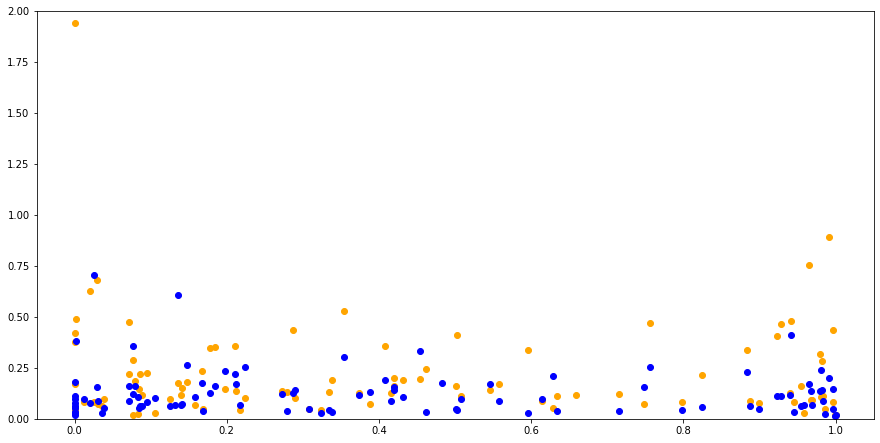

In [31]:
x = df_eval[df_eval["CATEGORY"]=="socialization"]
x1 = x[x["ID"].apply(lambda x: x.startswith("ARI"))]
x2 = x[x["ID"].apply(lambda x: x.startswith("OSC"))]
plt.scatter(x1["TEST_PVAL"], x1["rRMSEP"], color="orange")
plt.scatter(x2["TEST_PVAL"], x2["rRMSEP"], color="blue")
plt.ylim((0, 2))

MSSA python